**Step 1: Load and Clean Data**


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r"C:\Users\bezis\Downloads\Brent-Oil-Insights\data\raw\BrentOilPrices.csv")

data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data = data.sort_values('Date').dropna()

prices = data['Price'].values
dates = data['Date'].values

C:\Users\bezis\AppData\Local\Temp\ipykernel_25724\1403042462.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


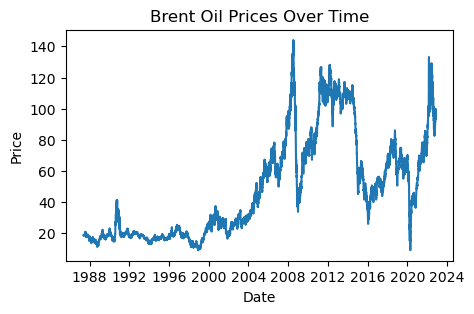

In [3]:
plt.figure(figsize=(5,3))
plt.plot(data['Date'], data['Price'])
plt.title("Brent Oil Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

**STEP 2 — Build Bayesian Change Point Model (PyMC)**


In [4]:
import pymc as pm
import arviz as az

c:\Users\bezis\anaconda3\envs\oil-change-point\lib\site-packages\arviz\__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [5]:
with pm.Model() as model:

    # 1️⃣ Prior for change point (tau)
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(prices)-1)

    # 2️⃣ Priors for means
    mu_1 = pm.Normal("mu_1", mu=np.mean(prices), sigma=20)
    mu_2 = pm.Normal("mu_2", mu=np.mean(prices), sigma=20)

    # 3️⃣ Prior for standard deviation
    sigma = pm.HalfNormal("sigma", sigma=10)

    # 4️⃣ Switch function
    mu = pm.math.switch(tau >= np.arange(len(prices)), mu_1, mu_2)

    # 5️⃣ Likelihood
    observation = pm.Normal("obs", mu=mu, sigma=sigma, observed=prices)

    # 6️⃣ Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu_1, mu_2, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 53 seconds.


- Check Convergence


In [6]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,4520.174,3.217,4513.000,4525.000,0.077,0.067,1700.0,1696.0,1.0
mu_1,21.427,0.278,20.888,21.932,0.003,0.003,11913.0,6749.0,1.0
mu_2,75.605,0.284,75.064,76.125,0.003,0.003,12068.0,5380.0,1.0
sigma,18.591,0.136,18.344,18.854,0.001,0.001,11763.0,6222.0,1.0


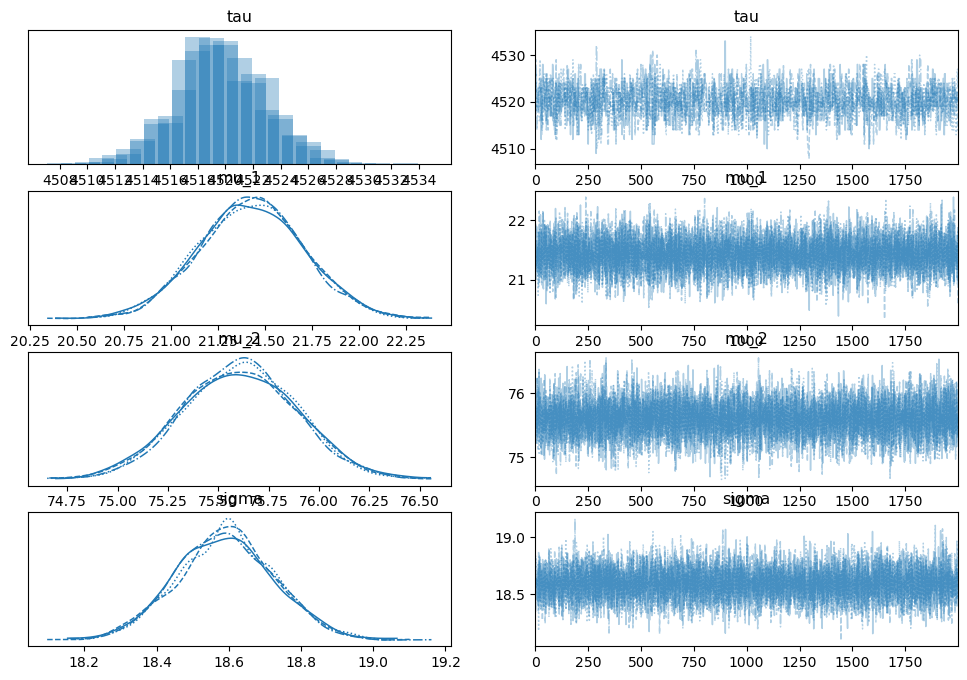

In [7]:
az.plot_trace(trace)
plt.show()

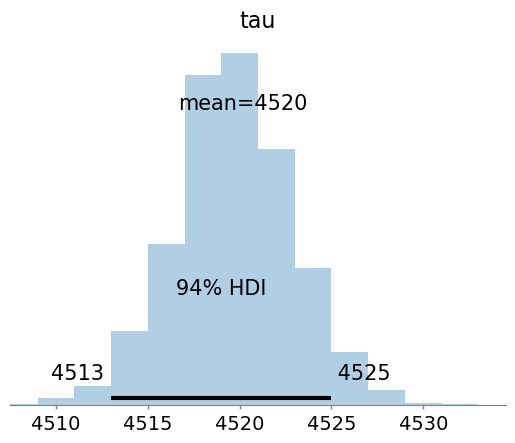

In [8]:
az.plot_posterior(trace, var_names=["tau"])
plt.show()

In [9]:
tau_samples = trace.posterior["tau"].values.flatten()
estimated_tau = int(np.mean(tau_samples))

change_date = data.iloc[estimated_tau]["Date"]

print("Estimated Change Point Date:", change_date)

Estimated Change Point Date: 2005-02-23 00:00:00


In [10]:
mu1_mean = trace.posterior["mu_1"].mean().values
mu2_mean = trace.posterior["mu_2"].mean().values

percent_change = ((mu2_mean - mu1_mean) / mu1_mean) * 100

print(f"Before mean price: ${mu1_mean:.2f}")
print(f"After mean price: ${mu2_mean:.2f}")
print(f"Percent change: {percent_change:.2f}%")

Before mean price: $21.43
After mean price: $75.61
Percent change: 252.85%


In [15]:
import numpy as np
import json

tau_samples = trace.posterior["tau"].values.flatten()
mu1_samples = trace.posterior["mu_1"].values.flatten()
mu2_samples = trace.posterior["mu_2"].values.flatten()
sigma_samples = trace.posterior["sigma"].values.flatten()

tau_mean = int(np.mean(tau_samples))
tau_ci = np.percentile(tau_samples, [2.5, 97.5])

mu1_mean = float(np.mean(mu1_samples))
mu2_mean = float(np.mean(mu2_samples))
sigma_mean = float(np.mean(sigma_samples))

percent_change = ((mu2_mean - mu1_mean) / mu1_mean) * 100

result = {
    "change_point_index": tau_mean,
   "change_point_date": data.iloc[tau_mean]["Date"].strftime("%Y-%m-%d"),
    "mean_before": mu1_mean,
    "mean_after": mu2_mean,
    "percent_change": float(percent_change),
    "volatility": sigma_mean,
    "credible_interval_tau": [
        int(tau_ci[0]),
        int(tau_ci[1])
    ]
}

with open("bayesian_change_point.json", "w") as f:
    json.dump(result, f, indent=4)

print("Bayesian change point results exported successfully.")

Bayesian change point results exported successfully.


In [14]:
print(dir())

['In', 'Out', '_', '_6', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '__vsc_ipynb_file__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'az', 'change_date', 'data', 'dates', 'estimated_tau', 'exit', 'f', 'get_ipython', 'json', 'model', 'mu', 'mu1_mean', 'mu1_samples', 'mu2_mean', 'mu2_samples', 'mu_1', 'mu_2', 'np', 'observation', 'open', 'pd', 'percent_change', 'plt', 'pm', 'prices', 'quit', 'result', 'sigma', 'sigma_mean', 'sigma_samples', 'tau', 'tau_ci', 'tau_mean', 'tau_samples', 'trace']
